In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
from tensorboardX import SummaryWriter
from tqdm import tqdm
import gc
from copy import deepcopy
from gym_multi_point import MultiPointEnv

import torch
import numpy as np
from torch import nn
import math
from models import *   
from train_barrier_multi_point import *
from core import generate_default_model_name

import scipy
from random import shuffle
import random
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from collections import defaultdict

# train offline

In [2]:
Env = MultiPointEnv
env = MultiPointEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
name_dict = generate_default_model_name(Env)
bnn = HeteroGNN(64, 3, keys=['agent'])
bnn.to(device)
# bnn.load_state_dict(torch.load(name_dict['db'], map_location=device))
bnn.train()

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


HeteroGNN(
  (embed): ModuleDict(
    (agent): Sequential(
      (0): LazyLinear(in_features=0, out_features=64, bias=False)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=1)
    (1): HeteroConv(num_relations=1)
    (2): HeteroConv(num_relations=1)
  )
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
)

In [3]:
@torch.no_grad()
def infer(env, verbose=False, seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    max_episode_length = 256
    total_trans=0; n_danger=0; threshold=THRESHOLD; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool)

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
        a_refines, bvalues = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        next_states = env.world.agents.reshape(env.num_agents, 1, -1)+0.3*a_refines
        dists = np.linalg.norm(next_states-env.world.agent_goals.reshape(env.num_agents, 1, -1), axis=-1)
        a = np.zeros((env.num_agents, env.action_dim))
        v = np.zeros(env.num_agents)
        for agent_id, a_refine, bvalue, dist in zip(np.arange(env.num_agents), a_refines, bvalues, dists):
            if np.any(bvalue>threshold):
                for a_idx in np.argsort(dist):
                    if bvalue[a_idx] > threshold:
                        a[agent_id] = a_refine[a_idx]
                        v[agent_id] = bvalue[a_idx]
                        break
            else:
                no_feasible += 1
                a[agent_id] = a_refine[np.argmax(bvalue)]
                v[agent_id] = bvalue[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)

        prev_danger = info['prev_danger']
        next_danger = info['next_danger']
        if np.any(next_danger):
            collided = collided | info['next_danger']
        if verbose:
            print(bvalues.min(axis=-1), bvalues.max(axis=-1), v, info['next_danger'])

        total_trans += 1

        if done or (total_trans >= max_episode_length):
            break

    return collided, done

In [4]:
from tqdm import tqdm

NUM_AGENTS = 3
MAP_SIZE = 3
OBSTACLE_DENSITY = 0.1

pos = np.array(np.meshgrid(np.linspace(0.5, 2.5, 3), np.linspace(0.5, 2.5, 3))).reshape(2, -1).T.tolist()
pos.pop(4)
pos = np.array(pos)

# generate training data
dataset = []
for _ in tqdm(range(20)):
    while True:
        env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
        env.world.obstacles = [[1.5, 1.5]]
        env.world.agents = pos[np.random.choice(len(pos), size=(3,), replace=False)]
        env.world.agent_goals = pos[np.random.choice(len(pos), size=(3,), replace=False)]
        if np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() > 2:
            break
    dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

# generate valid data
valid_dataset = []
for _ in tqdm(range(20)):
    while True:
        env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
        env.world.obstacles = [[1.5, 1.5]]
        env.world.agents = pos[np.random.choice(len(pos), size=(3,), replace=False)]
        env.world.agent_goals = pos[np.random.choice(len(pos), size=(3,), replace=False)]
        if np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() > 2:
            break
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

100%|██████████| 20/20 [00:00<00:00, 360.45it/s]


In [ ]:
from gym_multi_point import MultiPointEnv
from tqdm import tqdm
from collections import defaultdict
from copy import deepcopy

Env = MultiPointEnv
env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))

bnn = DBarrierGNN(state_dim=Env.state_dim, action_dim=Env.action_dim)
bnn.to(device)
bnn.train()

name_dict = generate_default_model_name(Env)
# bnn.load_state_dict(torch.load(name_dict['b'].replace('.pt', '_1model.pt'), map_location=device))

boptimizer = torch.optim.SGD(bnn.parameters(), lr=1e-4, momentum=0.9)#, weight_decay=1e-8)
bscheduler = torch.optim.lr_scheduler.ExponentialLR(boptimizer, gamma=0.89)  

writer = SummaryWriter()
writer.step = 0
max_episode_length = 256

BATCH = 32
N_ITER = 100
N_TRAJ = N_EPOCH = 100
N_TRAJ_PER_EPOCH = 1
N_BUFFER = 10
N_CBUF = 10000
N_EVALUATE = 20 # len(dataset)
N_LOG = 25000
N_WARMUP = 4 # len(dataset)
THRESHOLD=2e-2

running_unsafe_rate = 0
best_unsafe_rate = float('inf')
unsafe_rates = [1.]*N_EVALUATE
uncollide_rates = [1.]*N_EVALUATE
nominal_eps = 1.0
explore_eps = 1.0

trajs = defaultdict(list)
BMODEL_PATH = name_dict['db'].replace('.pt', '_fix.pt')
open('1model_fix_'+Env.__name__+'.txt', 'w+').close()
bbuf_gather = GatherReplayBuffer(BATCH)
cbuf = GlobalReplayBuffer()
fbuf = GlobalReplayBuffer()

pbar = tqdm(range(N_TRAJ))
for epoch_i in pbar:
    
    if (epoch_i % len(dataset) == 0):
        shuffle(dataset)
    
    bbuf = GlobalReplayBuffer()

    while True:
        env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
        env.world.obstacles = [[1.5, 1.5]]
        env.world.agents = pos[np.random.choice(len(pos), size=(3,), replace=False)]
        env.world.agent_goals = pos[np.random.choice(len(pos), size=(3,), replace=False)]
        if np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() > 2:
            break
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(dataset[epoch_i%len(dataset)])
#     half_size = MAP_SIZE / 2
#     env.world.agents = np.array([[half_size+(half_size-0.5)*np.cos(a), half_size+(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
#     env.world.agent_goals = np.array([[half_size-(half_size-0.5)*np.cos(a), half_size-(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
    
    # env.state = env.state + np.random.uniform(-2e-2, 2e-2, size=(2,))
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
    total_trans=0; n_danger=0; threshold=THRESHOLD; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool)

    while True:
        env.world.obstacles = [[]]
        o = env._get_obs()
        env.world.obstacles = [[1.5, 1.5]]
        
        a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))  # np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])

        # o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
        a_refines, bvalues = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)  # min(epoch_i//10, 30)

        dists = []
        next_states = env.world.agents.reshape(env.num_agents, 1, -1)+0.3*a_refines
        dists = np.linalg.norm(next_states-env.world.agent_goals.reshape(env.num_agents, 1, -1), axis=-1)
        a = np.zeros((env.num_agents, env.action_dim))
        for agent_id, a_refine, bvalue, dist in zip(np.arange(env.num_agents), a_refines, bvalues, dists):
            if epoch_i < N_WARMUP:  # warmup
                a[agent_id] = a_refine[np.argsort(dist)[0]]
            elif np.any(bvalue>threshold):
                for a_idx in np.argsort(dist):
                    if bvalue[a_idx] > threshold:
                        a[agent_id] = a_refine[a_idx]
                        break
            else:
                no_feasible += 1
                if np.random.rand()<explore_eps:
                    a[agent_id] = a_refine[np.random.randint(n_candidates)]
                else:
                    a[agent_id] = a_refine[np.argmax(bvalue)]

        # for zip(a, dists)

        # a, a_value = choose_action(a_refine, bvalue, threshold=threshold, explore_eps=0, nominal_eps=nominal_eps)  # 

        next_o, rw, done, info = env.step(a)

        bbuf.store(**info)
        prev_danger = info['prev_danger']
        next_danger = info['next_danger']
        if np.any(next_danger):
            info['prev_free'] = [False]*env.num_agents
            info['next_free'] = [False]*env.num_agents
            cbuf.store(**info)
            if len(cbuf.obs_buf) > N_CBUF:
                cbuf.obs_buf.pop(0)
            collided = collided | info['next_danger']

        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length):
            if n_danger==0:
                # only preserve the hard envs
                dataset.pop(epoch_i%len(dataset))
                while True:
                    env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
                    env.world.obstacles = [[1.5, 1.5]]
                    env.world.agents = pos[np.random.choice(len(pos), size=(3,), replace=False)]
                    env.world.agent_goals = pos[np.random.choice(len(pos), size=(3,), replace=False)]
                    if np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() > 2:
                        break
                dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))            

            # if n_danger!=0:
            #     meet_danger = False
            #     for o in bbuf.obs_buf:
            #         if meet_danger:
            #             o['prev_free'] = 0 * o['prev_free']
            #             o['next_free'] = 0 * o['next_free']
            #         if o['next_danger']:
            #             meet_danger = True
                # TODO: not feasible if next state is not feasible
                # for o in bbuf.obs_buf:
            bbuf_gather.append(bbuf)
            # else:
            #     fbuf.obs_buf.append(bbuf)
            break

    unsafe_rates.append(collided.mean())
    unsafe_rates.pop(0)
    uncollide_rates.append(np.any(collided))
    uncollide_rates.pop(0)    
    running_unsafe_rate = np.mean(unsafe_rates)

    if len(bbuf_gather.buffers) > N_BUFFER:
        bbuf_gather.buffers.pop(0)
        
    if (epoch_i % N_TRAJ_PER_EPOCH) == (N_TRAJ_PER_EPOCH-1) and (running_unsafe_rate!=0):
        if running_unsafe_rate < best_unsafe_rate:
            best_unsafe_rate = running_unsafe_rate
            torch.save(bnn.state_dict(), BMODEL_PATH)        
        
        bbuf_gather.buffers.append(cbuf)
        bnn.train()
        train_barrier(bnn, boptimizer, bbuf_gather, writer, pbar=pbar, n_iter=N_ITER)
        torch.save(bnn.state_dict(), BMODEL_PATH.replace('.pt', '_current.pt'))
        bbuf_gather.buffers.pop(-1)

        # if (epoch_i % 10 == 9):
        #     bscheduler.step()
        
    if (epoch_i % (N_TRAJ//20) == ((N_TRAJ//20)-1)):
        explore_eps = max(explore_eps * 0.8, 0.01)
        
        valid_loss = 0
        for data in valid_dataset:
            env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
            env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
            collided, done = infer(env)
            valid_loss += np.any(collided)
        torch.save(bnn.state_dict(), BMODEL_PATH.replace('.pt', '{0:d}_{1:.2f}.pt'.format(epoch_i, valid_loss/len(valid_dataset))))
        

    with open('1model_fix_'+Env.__name__+'.txt', 'a+') as f:
        f.write(pbar.desc+'\t'+str(epoch_i)+'\t'+'collided: {0:.2f}'.format(collided.mean())+' running rate: {0:.6f}, {1:6f}'.format(running_unsafe_rate, np.mean(uncollide_rates))+' no feasible: {0:d}'.format(no_feasible)+', buf size {0:d} {1:d} {2:d}'.format(len(bbuf.obs_buf), len(cbuf.obs_buf), len(fbuf.obs_buf))+'\n')

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
from torch_geometric.data import HeteroData
from torch_cluster import radius_graph, radius, knn_graph
data = HeteroData()
data['agent'].x = torch.FloatTensor(env.world.agents)
data['obstacle'].x = torch.FloatTensor(env.world.obstacles)

data['obstacle', 'o_near_a', 'agent'].edge_index = radius(data['agent'].x[:,:2], data['obstacle'].x[:,:2], r=3)
agent_to_agent = data['agent', 'a_near_a', 'agent'].edge_index = knn_graph(data['agent'].x[:,:2], 3, loop=False)

pairs = torch.FloatTensor(env.world.agents[:,:2])[agent_to_agent]
distance = (pairs[0] - pairs[1]).norm(dim=-1)
agent_to_agent = agent_to_agent[:, distance<3]
data['agent', 'a_near_a', 'agent'].edge_index = agent_to_agent

goals = env.world.agent_goals
clip_goal = (goals-env.world.agents).clip(-6, 6)+env.world.agents
data['goal'].x = torch.FloatTensor(env.world.agent_goals)
data['goal', 'toward', 'agent'].edge_index = torch.arange(env.num_agents).unsqueeze(0).repeat(2, 1).long()

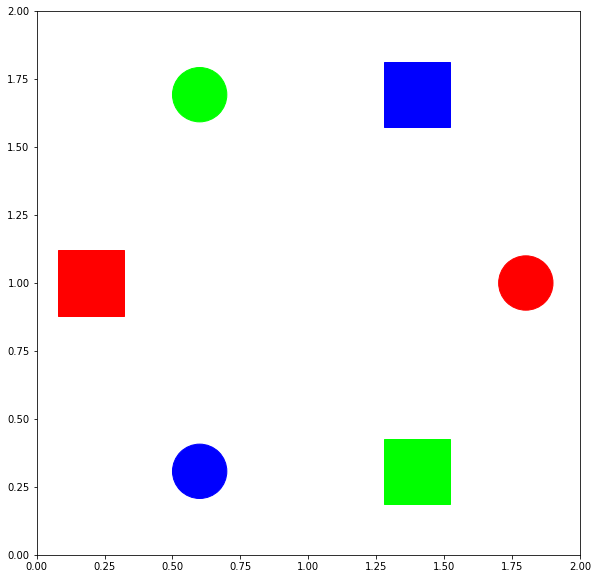

In [96]:
%notebook widget
import matplotlib.pyplot as plt
half_size = MAP_SIZE / 2

env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.agents = np.array([[half_size+(half_size-0.5)*np.cos(a), half_size+(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
env.world.agent_goals = np.array([[half_size-(half_size-0.5)*np.cos(a), half_size-(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
plt.imshow(env._render())
plt.show()

In [83]:
env._get_obs(mode='barrier')

{'x': tensor([[1.5000, 2.5000],
         [2.5000, 1.5000],
         [3.5000, 2.5000],
         [4.5000, 3.5000],
         [2.5000, 2.5000],
         [4.5000, 1.5000],
         [2.5000, 3.5000]]),
 'edge_index': tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6],
         [4, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6]]),
 'label': tensor([[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]),
 'goal': tensor([[1.5000, 3.5000],
         [3.5000, 0.5000],
         [2.5000, 3.5000]])}

In [81]:
from torch_geometric.data import Data
bnn(**Data(**env._get_obs(mode='barrier')).to(device).to_dict(), action=torch.rand(3,2).uniform_(-1,1).to(device))

tensor([0.0206, 0.1583, 0.0911], device='cuda:0', grad_fn=<SqueezeBackward1>)

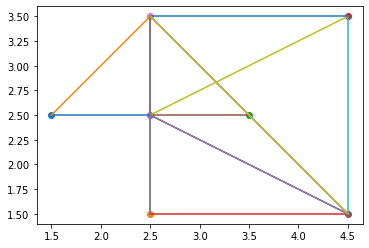

In [43]:
plt.clf()
plt.close('all')
# env._render()
x = env._get_obs(mode='barrier')['x'].data.cpu().numpy()
for node in x:
    plt.scatter(node[0], node[1])
edges = env._get_obs(mode='barrier')['edge_index'].data.cpu().numpy().T
for edge in edges:
    a, b = edge
    plt.plot([x[a][0], x[b][0]], [x[a][1], x[b][1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [69]:
%debug

> /home/rainorangelemon/Documents/CAM/train_barrier_multi_point.py(38)compute_loss()
     36     # Set up function for computing value loss
     37     def compute_loss(bnn, data, next_data):
---> 38         value = bnn(**data)
     39         next_value = bnn(**next_data)
     40 



ipdb>  data


Batch(x=[42, 2], edge_index=[2, 76], label=[42, 3], goal=[18, 2], action=[18, 2], prev_free=[18], prev_danger=[18], next_goal=[18], next_free=[18], next_danger=[18], batch=[42], ptr=[7])


ipdb>  data.to_dict()


{'x': tensor([[1.5000, 5.5000],
        [2.5000, 2.5000],
        [6.5000, 1.5000],
        [7.5000, 7.5000],
        [4.5000, 5.5000],
        [6.5000, 4.5000],
        [7.5000, 3.5000],
        [1.5000, 5.5000],
        [2.5000, 2.5000],
        [6.5000, 1.5000],
        [7.5000, 7.5000],
        [4.2022, 5.2004],
        [6.4385, 4.7992],
        [7.2021, 3.4525],
        [1.5000, 5.5000],
        [2.5000, 2.5000],
        [6.5000, 1.5000],
        [7.5000, 7.5000],
        [4.5000, 5.5000],
        [6.5000, 4.5000],
        [7.5000, 3.5000],
        [1.5000, 5.5000],
        [2.5000, 2.5000],
        [6.5000, 1.5000],
        [7.5000, 7.5000],
        [3.9096, 4.9023],
        [6.5657, 5.0959],
        [6.9042, 3.5418],
        [1.5000, 5.5000],
        [2.5000, 2.5000],
        [6.5000, 1.5000],
        [7.5000, 7.5000],
        [4.2022, 5.2004],
        [6.4385, 4.7992],
        [7.2021, 3.4525],
        [1.5000, 5.5000],
        [2.5000, 2.5000],
        [6.5000, 1.5000],
      

ipdb>  exit()


In [38]:
n_d = 0
for d in cbuf.obs_buf:
    if d['prev_danger'].any():
        n_d += 1
        print('--------------------------------')
        print(d['next_danger'], bnn(**d.to(device).to_dict()))
        for _ in range(10):
            a = torch.FloatTensor(d['action'].shape).uniform_(-1, 1)
            d = d.clone()
            d['action'] = a
            print(bnn(**d.to(device).to_dict()))
print(n_d)

--------------------------------
tensor([0., 1., 1.], device='cuda:0') tensor([ 0.1652, -0.0763, -0.0466], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1652, -0.0293, -0.0148], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1696, -0.0776, -0.0203], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1645, -0.0623, -0.0178], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1440, -0.0246, -0.0134], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1463, -0.0316, -0.0201], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1693, -0.0705, -0.0235], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1694, -0.0593, -0.0134], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1642, -0.0825, -0.0246], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1470, -0.0808, -0.0116], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1665, -0.0748, -0.0430], device='cuda:

In [20]:
d

Data(x=[4, 2], edge_index=[2, 8], label=[4, 3], goal=[3, 2], action=[3, 2], prev_free=[3], prev_danger=[3], next_goal=[3], next_free=[3], next_danger=[3])

In [451]:
bnn(x=cbuf.obs_buf[0]['x'].to(device), action=cbuf.obs_buf[0]['action'].to(device))

tensor(-0.1215, device='cuda:0', grad_fn=<SqueezeBackward1>)

In [415]:
cbuf.obs_buf[0]['action'].to(device)

tensor([-0.8627, -1.0000], device='cuda:0')

In [434]:
torch.rand(2).uniform_(-1, 1)

tensor([-0.5567,  0.0523])

## check on existing data

In [55]:
total_buffer = []
total_buffer_a = []
total_buffer_d = []
total_buffer.extend([o['x'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])
total_buffer_a.extend([o['action'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])
total_buffer_d.extend([o['next_danger'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])

In [ ]:
total_buffer

In [453]:
len(total_buffer)

32830

In [454]:
len(cbuf.obs_buf)

103

In [392]:
total_buffer = np.array(total_buffer)
total_buffer_a = np.array(total_buffer_a)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(total_buffer)
dists, idxs = nbrs.kneighbors(total_buffer, 10, return_distance=True)
best_idx = dists.mean(axis=-1).argmin()
random_data = total_buffer[best_idx]
dists, idxs = nbrs.kneighbors([random_data], 10, return_distance=True)
total_buffer_a[idxs], dists

# inference

In [ ]:
from gym_multi_point import MultiPointEnv
from stable_baselines3 import PPO
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Env = MultiPointEnv
env = MultiPointEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
nominal_control = lambda x: np.clip(np.array([2, 0])-x, -1, 1)
name_dict = generate_default_model_name(Env)

bnn = DMLP(state_dim=Env.state_dim, action_dim=Env.action_dim, mode='straight')
CURRENT_BMODEL_PATH = name_dict['db'].replace('.pt', '_current.pt')
bnn.load_state_dict(torch.load(CURRENT_BMODEL_PATH, map_location=device))
bnn.to(device)
bnn.eval()

writer = SummaryWriter()
writer.step = 0
max_episode_length = 256
BATCH = 64
N_ITER = 1

### visualization on traj

In [43]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 1000
infer_traj = [env.reset()]
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
total_trans=0; n_danger=0; threshold=2e-2

env.state = env.state + np.random.uniform(-2e-2, 2e-2, size=(2,))
while True:
    o = env._get_obs()
    a_all = np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))  # np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])
    # a_all[0, :] = nominal_control(o)

    o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
    a_refine, bvalue = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

    dists = []
    for a in a_refine:
        next_state = a + env.state
        dists.append(np.linalg.norm(next_state-np.array([2, 0])))
    if np.any(bvalue>threshold):
        for a_idx in np.argsort(dists):
            if bvalue[a_idx] > threshold:
                a = a_refine[a_idx]
                a_value = bvalue[a_idx]
                break
    else:
        no_feasible += 1
        a = a_refine[np.argmax(bvalue)]
        a_value = bvalue[np.argmax(bvalue)]

    next_o, rw, done, info = env.step(a)
    infer_traj.append(env.state.copy())
    # if info['next_danger']:
    print(bvalue.min(), bvalue.max(), a_value, 'TRUE' if info['next_danger'] else '')
    n_collide += info['next_danger']

    total_trans += 1
    n_danger += np.array(next_danger).sum()

    if done or (total_trans >= max_episode_length):
        n_reach += info['next_goal']
        break

-0.011454485 0.0100880265 0.0100880265 
-0.0005645901 0.034730665 0.021317631 
-0.0103029385 0.03717588 0.023276329 
-0.025843248 0.036976457 0.020160131 
-0.041640263 0.03583748 0.020442158 
-0.051481336 0.047509983 0.020227335 
-0.06575713 0.051302724 0.023434944 
-0.07435175 0.053191707 0.021078765 
-0.06207292 0.06750652 0.022992529 
-0.040239707 0.08258632 0.020513423 
-0.010828562 0.09949966 0.024549022 
-0.00047008693 0.099690884 0.044442058 
0.024240538 0.112767756 0.07363181 
0.04954586 0.13239495 0.09987557 
0.07040426 0.14830104 0.11921558 
0.084665716 0.15895973 0.13067153 
0.09051208 0.16474299 0.13799097 
0.09720206 0.16983302 0.14433394 
0.10149008 0.17463066 0.14820996 


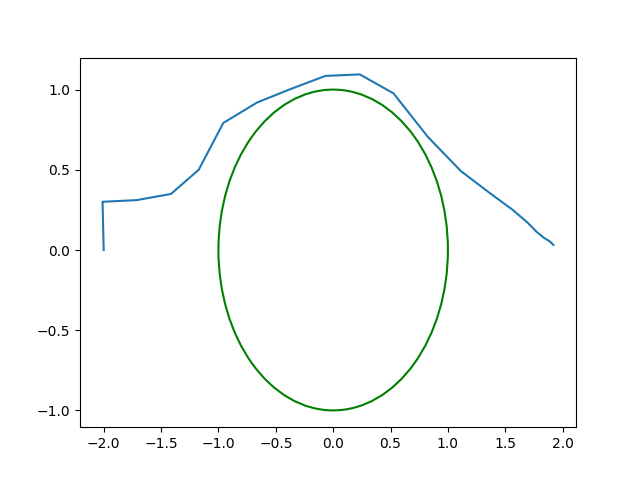

In [44]:
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(infer_traj).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()

### visualization on CBF

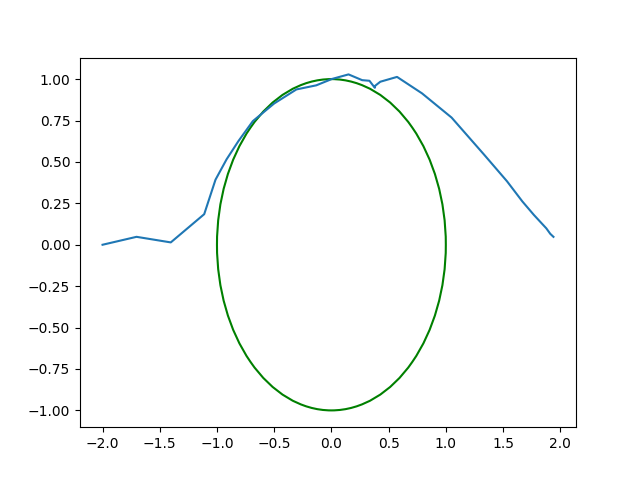

In [30]:
%matplotlib widget
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(trajs[24]).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()

In [59]:
bnn(x=torch.FloatTensor(np.array(trajs[99])[:-1]).to(device), action=torch.FloatTensor(np.array(trajs[99])[1:,]-np.array(trajs[99])[:-1]).to(device)/0.3).data.cpu().numpy()

array([ 0.00615322,  0.0168369 ,  0.02461939,  0.03725697, -0.04950445,
        0.04675311, -0.01833821,  0.03422268,  0.08368017,  0.09180238,
        0.20361288,  0.3725643 ,  0.5286677 ,  0.6686999 ,  0.7717982 ,
        0.8585829 ,  0.907426  ,  0.94885206,  0.979881  ], dtype=float32)

In [42]:
trajs[59][1]

array([-1.73082578, -0.24192397])

In [133]:
bnn(x=torch.FloatTensor([-1.1, 0]).to(device), action=torch.FloatTensor([0.4, 0]).to(device))

tensor(0.0157, device='cuda:0', grad_fn=<SqueezeBackward1>)

### G

In [37]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 1000
env.reset()
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
total_trans=0; n_danger=0; threshold=1e-2

while True:
    o = env._get_obs()
    a_best = nominal_control(o)
    a_other = np.random.uniform(-1., 1., size=(n_candidates-1, env.action_dim))
    a_all = np.zeros((n_candidates, env.action_dim))
    a_all[0, :] = a_best
    a_all[1:, :] = a_other

    o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
    a_refine, bvalue = iter_action(bnn, o, a_other, max_iter=0, threshold=threshold)

    a, a_value = choose_action(a_refine, bvalue, threshold=threshold, explore_eps=0., nominal_eps=0.)

    next_o, rw, done, info = env.step(a_best)
    # if info['next_danger']:
    print(o['x'], a_value)
    n_collide += info['next_danger']

    threshold = 1e-2
    total_trans += 1
    n_danger += np.array(next_danger).sum()

    if done or (total_trans >= max_episode_length):
        n_reach += info['next_goal']
        break

tensor([-2.,  0.]) -0.13107894
tensor([-1.7000,  0.0000]) -0.122936025
tensor([-1.4000,  0.0000]) -0.11164804
tensor([-1.1000,  0.0000]) -0.10055794
tensor([-0.8000,  0.0000]) -0.09046771
tensor([-0.5000,  0.0000]) -0.082239956
tensor([-0.2000,  0.0000]) -0.0731955
tensor([0.1000, 0.0000]) -0.06821193
tensor([0.4000, 0.0000]) -0.07327388
tensor([0.7000, 0.0000]) -0.06384854
tensor([1., 0.]) -0.07175657
tensor([1.3000, 0.0000]) -0.08446115
tensor([1.5100, 0.0000]) -0.08590387
tensor([1.6570, 0.0000]) -0.079477355
tensor([1.7599, 0.0000]) -0.095163316
tensor([1.8319, 0.0000]) -0.08545959
tensor([1.8824, 0.0000]) -0.08211541


# benchmark

In [31]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 100

for _ in tqdm(range(N_TEST)):
    
    infer_traj = [env.reset()]
    total_trans=0; n_danger=0; threshold=2e-2; collided=False
    env.state = env.state + np.random.uniform(-5e-2, 5e-2, size=(2,))

    while True:
        o = env._get_obs()
        a_all = np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])  #np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))

        o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
        a_refine, bvalue = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        for a in a_refine:
            next_state = a + env.state
            dists.append(np.linalg.norm(next_state-np.array([2, 0])))
        if np.any(bvalue>threshold):
            for a_idx in np.argsort(dists):
                if bvalue[a_idx] > threshold:
                    a = a_refine[a_idx]
                    break
        else:
            a = a_refine[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)
        infer_traj.append(env.state.copy())
        # if info['next_danger']:
        # print(bvalue[0], bvalue.min(), bvalue.max(), threshold, a_value, 'TRUE' if info['next_danger'] else '')
        if info['next_danger']:
            collided = True
        
        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length):
            n_collide += collided
            n_reach += info['next_goal']
            break

100%|██████████| 100/100 [00:04<00:00, 21.83it/s]


In [32]:
n_collide

0

In [33]:
n_reach

100